#  Классификация изображений с помощью сверточных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann 
* https://pytorch.org/docs/stable/nn.html#convolution-layers
* https://pytorch.org/vision/0.16/transforms.html#v2-api-reference-recommended
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
* https://kozodoi.me/blog/20210308/compute-image-stats
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.matshow.html

## Задачи для совместного разбора

1\. Рассмотрите основные возможности по созданию датасетов из `torchvision` и примеры работы основных слоев для создания сверточных нейронных сетей для анализа изображений.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

images, labels = next(iter(trainloader))
print("Размер batch:", images.shape)  # (4, 3, 32, 32)

conv = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
out = conv(images)
print("После Conv2d:", out.shape)

pool = nn.MaxPool2d(2, 2)
out = pool(out)
print("После MaxPool2d:", out.shape)


100%|██████████| 170M/170M [01:54<00:00, 1.49MB/s] 


Размер batch: torch.Size([4, 3, 32, 32])
После Conv2d: torch.Size([4, 6, 28, 28])
После MaxPool2d: torch.Size([4, 6, 14, 14])


2\. Реализуйте типовую архитектуру CNN для классификации изображений.

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)      # вход: 3 канала (RGB), выход: 6 карт признаков
        self.pool = nn.MaxPool2d(2, 2)       # уменьшаем размер в 2 раза
        self.conv2 = nn.Conv2d(6, 16, 5)     # вторая свёртка
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)         # 10 классов CIFAR10

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # вытягиваем в вектор
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = SimpleCNN()
print(net)

out = net(images)
print("Выход модели:", out.shape)  # (batch, 10)


SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Выход модели: torch.Size([4, 10])


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Создайте датасет `CatBreeds` на основе данных из архива `cat_breeds_4.zip`. Используя преобразования `torchvision`, приведите картинки к размеру 300х300 и нормализуйте значения интенсивности пикселей (рассчитайте статистику для нормализации отдельно). Выведите на экран количество картинок в датасете,  размер одной картинки, количество уникальных классов. Разбейте датасет на обучающее и тестовое множество в соотношении 80 на 20%.

- [ ] Проверено на семинаре

In [25]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Используемое устройство:", device)

Используемое устройство: mps


In [6]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])


dataset = ImageFolder(root="data/cat_breeds_4", transform=transform)


print("Всего изображений:", len(dataset))
print("Количество классов:", len(dataset.classes))
print("Классы:", dataset.classes)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


Всего изображений: 4000
Количество классов: 4
Классы: ['American Shorthair', 'Persian', 'Russian Blue', 'Tiger']


<p class="task" id="2"></p>

2\. Решите задачу классификации на основе датасета из предыдущего задания, не используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели.   

- [ ] Проверено на семинаре

In [21]:
class SimpleFC(nn.Module):
    def __init__(self):
        super(SimpleFC, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*300*300, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, len(dataset.classes))
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleFC()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)



train_losses = []
train_acc = []
test_acc = []

epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    acc_train = 100. * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_acc.append(acc_train)
    
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()
    acc_test = 100. * correct_test / total_test
    test_acc.append(acc_test)
    
    print(f"Эпоха {epoch+1}: Train Loss={train_losses[-1]:.3f}, Train Acc={acc_train:.2f}%, Test Acc={acc_test:.2f}%")





Эпоха 1: Train Loss=22.586, Train Acc=28.97%, Test Acc=35.75%
Эпоха 2: Train Loss=4.175, Train Acc=33.50%, Test Acc=32.75%
Эпоха 3: Train Loss=2.838, Train Acc=36.81%, Test Acc=32.25%
Эпоха 4: Train Loss=1.836, Train Acc=36.75%, Test Acc=28.25%
Эпоха 5: Train Loss=1.472, Train Acc=40.94%, Test Acc=24.62%


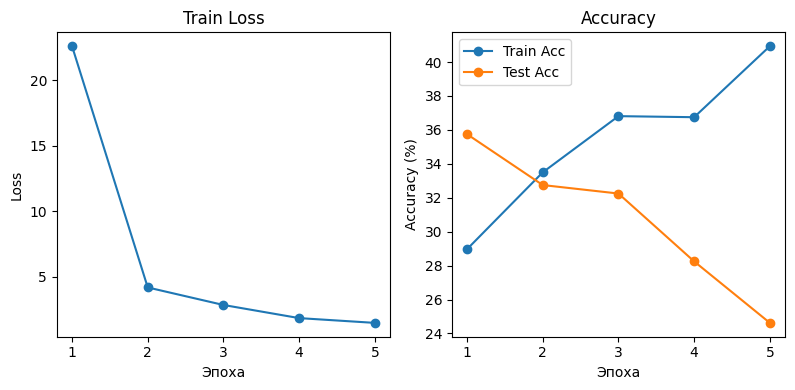

In [22]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.title("Train Loss")
plt.xlabel("Эпоха")
plt.ylabel("Loss")

plt.subplot(1,3,2)
plt.plot(range(1, epochs+1), train_acc, marker='o', label="Train Acc")
plt.plot(range(1, epochs+1), test_acc, marker='o', label="Test Acc")
plt.title("Accuracy")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy (%)")
plt.legend()



plt.tight_layout()
plt.show()

<p class="task" id="3"></p>

3\. Напишите функцию, которая выбирает несколько изображений из переданного набора данных и выводит их на экран в виде сетки с указанием над ними названия правильного класса и класса, предсказанного моделью. Воспользовавшись данной функцией, выведите прогнозы итоговой модели из предыдущей задачи по 6 случайным картинкам.

```
def show_examples(model, dataset, k=6):
    pass
```

- [ ] Проверено на семинаре

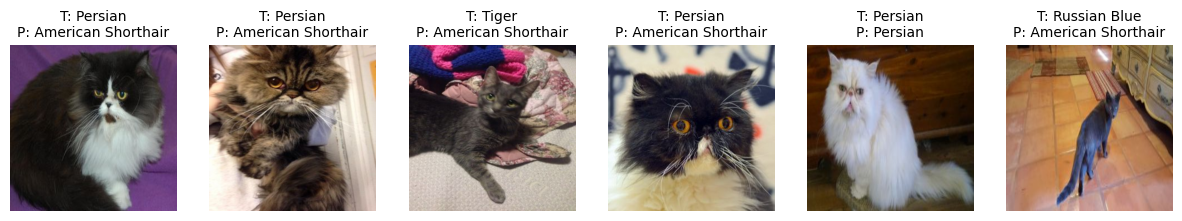

In [23]:
import matplotlib.pyplot as plt
import random
import torch

def show_examples(model, dataset, k=6, class_names=None, device="cpu"):
    model.eval()
    fig, axes = plt.subplots(1, k, figsize=(15, 3))
    
    for i in range(k):
        idx = random.randint(0, len(dataset)-1)
        image, label = dataset[idx]
        
        # добавляем размерность batch и переносим на device
        input_img = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(input_img)
            _, predicted = outputs.max(1)
        
        # картинка для вывода
        img = image.permute(1, 2, 0).numpy()  # C,H,W → H,W,C
        
        axes[i].imshow(img)
        axes[i].axis("off")
        
        true_class = class_names[label] if class_names else str(label)
        pred_class = class_names[predicted.item()] if class_names else str(predicted.item())
        axes[i].set_title(f"T: {true_class}\nP: {pred_class}", fontsize=10)
    
    plt.show()

show_examples(model, test_ds, k=6, class_names=dataset.classes, device="cpu")

<p class="task" id="4"></p>

4\. Решите задачу классификации на основе датасета из первого задания, используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели. Воспользовавшись функцией из предыдущего задания, выведите прогнозы итоговой модели по 6 случайным картинкам.

- [ ] Проверено на семинаре

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class CatCNN(nn.Module):
    def __init__(self, num_classes):
        super(CatCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)   # (3,128,128) -> (16,128,128)
        self.pool = nn.MaxPool2d(2, 2)                           # -> (16,64,64)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # -> (32,64,64) -> pool -> (32,32,32)
        self.fc1 = nn.Linear(32*75*75, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cat_model = CatCNN(num_classes=len(dataset.classes)).to(device)
print(cat_model)



CatCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=180000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


In [29]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cat_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

train_losses, train_acc, test_acc = [], [], []
epochs = 5

for epoch in range(epochs):
    # === train ===
    
    cat_model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cat_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    acc_train = 100. * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_acc.append(acc_train)
    
    # === test ===
    cat_model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cat_model(images)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()
    acc_test = 100. * correct_test / total_test
    test_acc.append(acc_test)
    
    print(f"Эпоха {epoch+1}: Loss={train_losses[-1]:.3f}, Train Acc={acc_train:.2f}%, Test Acc={acc_test:.2f}%")
    
    scheduler.step()


Эпоха 1: Loss=1.626, Train Acc=35.19%, Test Acc=40.25%
Эпоха 2: Loss=1.180, Train Acc=50.34%, Test Acc=49.88%
Эпоха 3: Loss=0.995, Train Acc=59.09%, Test Acc=54.25%
Эпоха 4: Loss=0.834, Train Acc=67.59%, Test Acc=53.75%
Эпоха 5: Loss=0.616, Train Acc=79.16%, Test Acc=49.75%


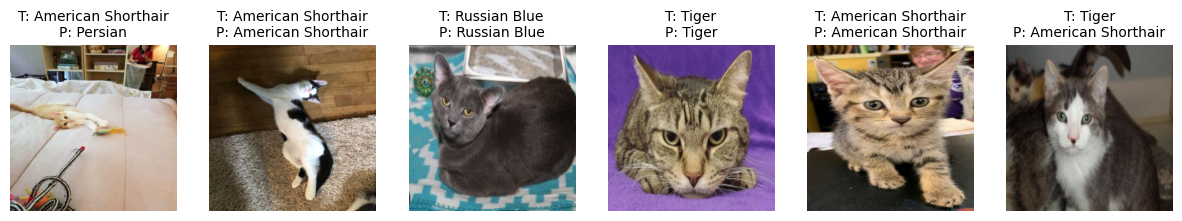

In [34]:
show_examples(cat_model, test_ds, k=6, class_names=dataset.classes, device=device)


<p class="task" id="5"></p>

5\. Проанализируйте обученную в предыдущей задаче модель, исследовав обученные ядра сверточных слоев. Выберите одно изображение из тестового набора данных и пропустите через первый сверточный слой модели. Визуализируйте полученные карты признаков.

- [ ] Проверено на семинаре

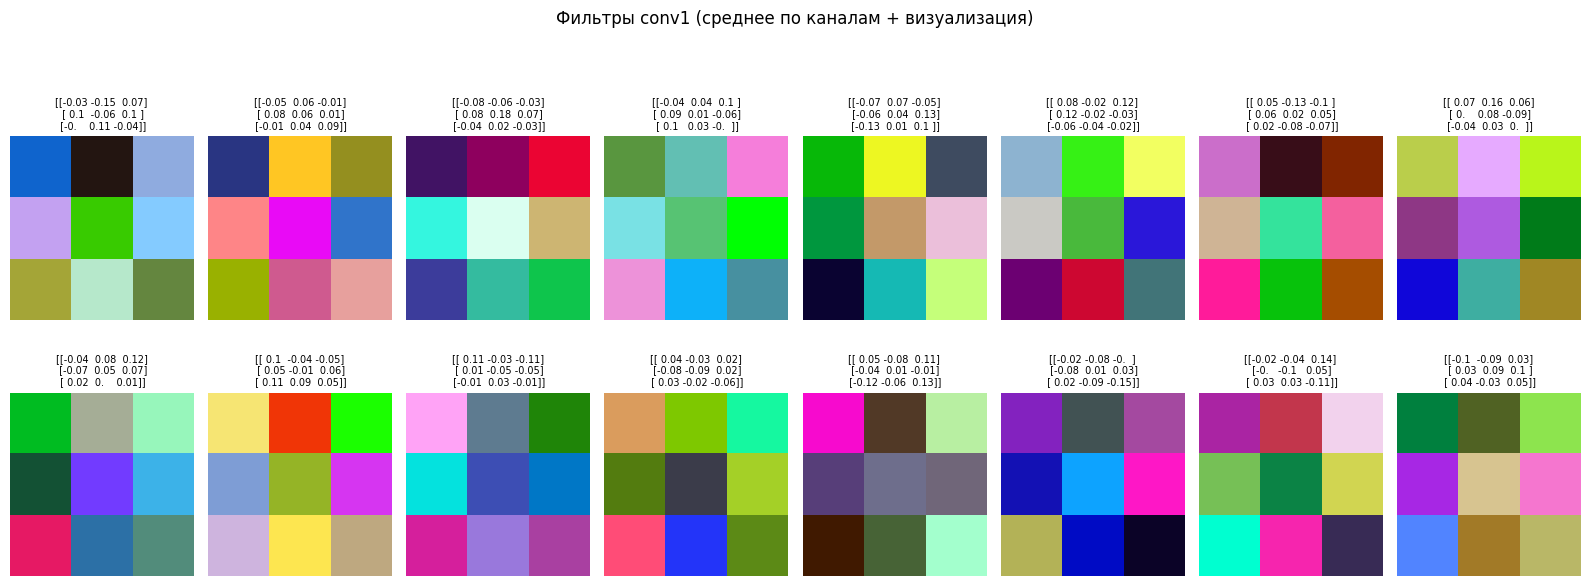

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

weights = cat_model.conv1.weight.data.cpu()

fig, axes = plt.subplots(2, 8, figsize=(16, 6))

for i, ax in enumerate(axes.flat):
    if i < weights.shape[0]:
        w = weights[i].permute(1, 2, 0).numpy()  # (C,H,W) → (H,W,C)
        
        w_img = (w - w.min()) / (w.max() - w.min())
        ax.imshow(w_img)
        ax.axis("off")
        
        # считаем усреднённый фильтр (3x3 если kernel_size=3)
        w_mean = w.mean(axis=2)   # усредняем по каналам
        ax.set_title(str(np.round(w_mean, 2)), fontsize=7)

plt.suptitle("Фильтры conv1 (среднее по каналам + визуализация)", y=1.05)
plt.tight_layout()
plt.show()


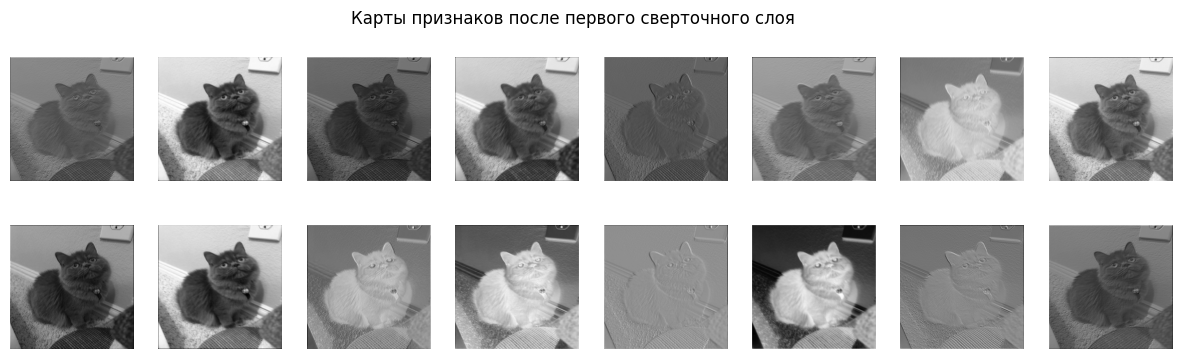

In [ ]:
import torch

image, label = test_ds[0]
input_img = image.unsqueeze(0).to(device)

with torch.no_grad():
    features = cat_model.conv1(input_img)

features = features.cpu().squeeze(0)  # (num_filters, H, W)

fig, axes = plt.subplots(2, 8, figsize=(15, 4))
for i, ax in enumerate(axes.flat):
    if i < features.shape[0]:
        ax.imshow(features[i].numpy(), cmap="gray")
        ax.axis("off")
plt.suptitle("Карты признаков после первого сверточного слоя")
plt.show()


## Обратная связь
- [ ] Хочу получить обратную связь по решению